In [1]:
from sqlalchemy import create_engine, text 
import pandas as pd 
import numpy as np 

In [2]:
sql = "SELECT * FROM books"
connection_string = "sqlite:////Users/flint/Data/kaggle/books/book-recommender/booksdb2.sql"

In [3]:
engine = create_engine(connection_string)
conn = engine.connect()
books = pd.read_sql(text(sql), con=conn)
conn.close()

In [4]:
books.head(2)

,book_id_mapping,title,num_pages,name
0,808,Pride and Prejudice and Zombies Pride and Prej...,320,Jane Austen
1,217,Blue Bloods Blue Bloods 1,302,Melissa de la Cruz


## Raccomandazione
Voglio raccomandare a un utente libri che non ha ancora letto (votato) ma che sono stati letti da utenti simili a lui
1. Criterio di similarità fra utenti
2. (Clustering)
3. Preso un utente $u$:
   1. Estraggo i $k$ utenti più simili (K)
   2. L'insieme dei libri letti (votati) da K
   3. Determino l'insieme $U$ dei libri letti da $u$ e calcolo $C = K - U$
   4. Faccio un ranking di $C$

### Similarità fra utenti
- Due utenti sono simili se danno voti simili alle stesse **cose** 
- Dove **cose** può riferirsi a:
  - libri
  - <u>generi</u>
  - autori

### Task 1: rappresentare le preferenze degli utenti per i generi letterari

In [5]:
user_profile = """
SELECT R.user_id_mapping, G.genre,
    AVG(R."Actual Rating") AS score
FROM genre AS G JOIN ratings AS R
ON G.book = R.book_id_mapping
GROUP BY user_id_mapping, genre
"""

In [6]:
conn = engine.connect()
profiles = pd.read_sql(text(user_profile), con=conn)
conn.close()

In [11]:
profiles

,user_id_mapping,genre,score
0,2,"fantasy, paranormal",4.0
1,2,fiction,4.0
2,2,romance,4.0
3,2,young-adult,4.0
4,4,children,3.0
...,...,...,...
72437,84260,romance,3.0
72438,84260,young-adult,3.0
72439,84282,"fantasy, paranormal",3.0
72440,84282,fiction,3.0


In [7]:
genre_list = list(profiles.genre.unique())
n = len(profiles.genre.unique())
n, genre_list

(10,
 ['fantasy, paranormal',
  'fiction',
  'romance',
  'young-adult',
  'children',
  'comics, graphic',
  'history, historical fiction, biography',
  'non-fiction',
  'mystery, thriller, crime',
  'poetry'])

In [12]:
profiles[profiles['user_id_mapping'] == 84260]

,user_id_mapping,genre,score
72435,84260,children,3.0
72436,84260,fiction,3.0
72437,84260,romance,3.0
72438,84260,young-adult,3.0


### Parentesi con matrice casuale

In [32]:
m = np.random.randint(0, 10, size=(4, 3))

In [51]:
m = m.T 

In [52]:
m

array([[9, 8, 9, 8],
       [1, 5, 2, 6],
       [3, 5, 5, 1]])

### Fine parentesi, torniamo ai generi

In [65]:
user_list = list(profiles.user_id_mapping.unique())
u = len(user_list)

In [68]:
profile_m = np.zeros((u, n))
profile_m.shape 
user_id_col = profiles.user_id_mapping.values
genre_id_col = profiles.genre.values
score_id_col = profiles.score.values
for i, user_id in enumerate(user_id_col):
    genre_id = genre_id_col[i]
    score_id = score_id_col[i]
    user_pos = user_list.index(user_id)
    genre_pos = genre_list.index(genre_id)
    profile_m[user_pos, genre_pos] = score_id
    

### Etichettatura utenti

In [70]:
profile_df = pd.DataFrame(
    profile_m, index=user_list, columns=genre_list)

In [72]:
profile_df.head(2)

,"fantasy, paranormal",fiction,romance,young-adult,children,"comics, graphic","history, historical fiction, biography",non-fiction,"mystery, thriller, crime",poetry
2,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0


In [88]:
mx = np.argmax(profile_m, axis=1)
user_labels = [genre_list[x] for x in mx]
user_labels[:6]

['fantasy, paranormal',
 'fantasy, paranormal',
 'fiction',
 'fantasy, paranormal',
 'fantasy, paranormal',
 'fantasy, paranormal']

In [93]:
profile_m.sum(axis=1)

array([16., 12., 24., ..., 15., 12.,  9.])

### Data normalization

In [97]:
profile_df.describe().T

,count,mean,std,min,25%,50%,75%,max
"fantasy, paranormal",17103.0,2.559527,2.003249,0.0,0.0,3.0,4.0,5.0
fiction,17103.0,3.803456,1.126324,0.0,3.0,4.0,5.0,5.0
romance,17103.0,2.421252,2.019628,0.0,0.0,3.0,4.0,5.0
young-adult,17103.0,2.907697,1.853837,0.0,1.0,3.5,4.0,5.0
children,17103.0,0.869730,1.692485,0.0,0.0,0.0,0.0,5.0
"comics, graphic",17103.0,0.588522,1.440858,0.0,0.0,0.0,0.0,5.0
"history, historical fiction, biography",17103.0,1.016138,1.811343,0.0,0.0,0.0,1.0,5.0
non-fiction,17103.0,0.780769,1.634942,0.0,0.0,0.0,0.0,5.0
"mystery, thriller, crime",17103.0,1.264525,1.918138,0.0,0.0,0.0,3.0,5.0
poetry,17103.0,0.162837,0.805598,0.0,0.0,0.0,0.0,5.0


### Plots

In [98]:
import matplotlib.pyplot as plt 
import seaborn as sns 

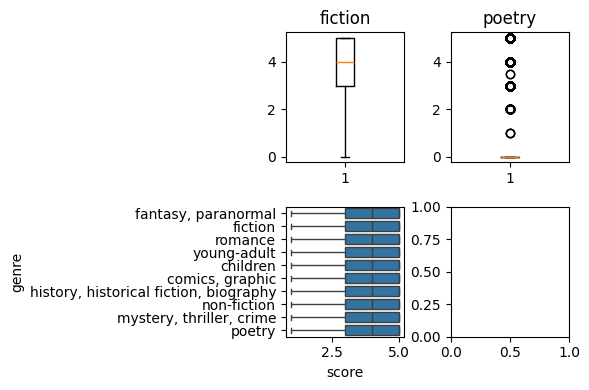

In [109]:
fig, ax = plt.subplots(figsize=(6, 4), ncols=2, nrows=2)
ax[0, 0].boxplot(profile_df['fiction'])
ax[0, 0].set_title('fiction')
ax[0, 1].boxplot(profile_df['poetry'])
ax[0, 1].set_title('poetry')
sns.boxplot(data=profiles, x='score', y='genre', ax=ax[1, 0])
plt.tight_layout()
plt.show()

### Esempio IDF e numpy broadcasting

In [126]:
boolean_profiles = profile_m > 0
idf = np.log(profile_m.shape[0] / boolean_profiles.sum(axis=0))
profile_mdf = profile_m * idf 

In [127]:
profile_mdf[0]

array([1.62993734, 0.07102384, 1.81556547, 1.07390159, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

### Vector Space visualizzazione

In [133]:
from sklearn.manifold import TSNE

In [134]:
transformer = TSNE(n_components=2)
profile_2d = transformer.fit_transform(profile_mdf)

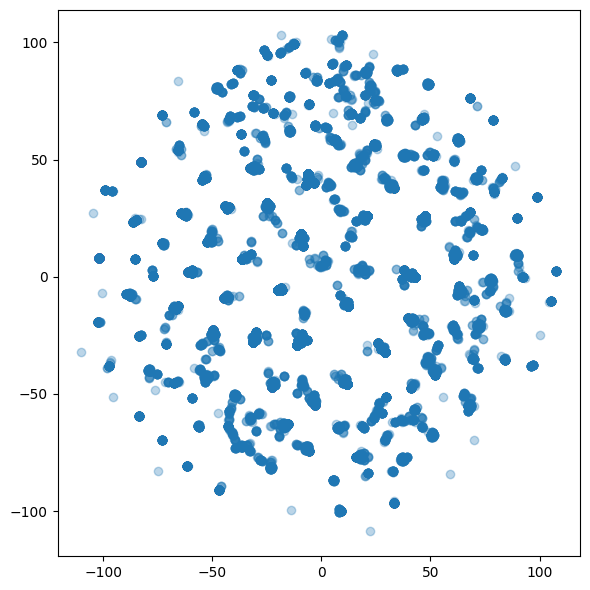

In [139]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(profile_2d[:, 0], profile_2d[:, 1], 
        alpha=0.3)
plt.tight_layout()
plt.show()

In [143]:
user_labels = [genre_list[x] for x in np.argmax(
    profile_mdf, axis=1)]
user_labels[:6]

['romance',
 'children',
 'comics, graphic',
 'mystery, thriller, crime',
 'comics, graphic',
 'poetry']

In [145]:
df2d = pd.DataFrame(profile_2d, index=user_list, columns=['D1', 'D2'])

In [147]:
df2d['label'] = user_labels
df2d

,D1,D2,label
2,10.781442,-11.261732,romance
4,-21.499943,-45.568783,children
7,63.295113,-5.626843,"comics, graphic"
21,-77.080658,0.477686,"mystery, thriller, crime"
23,36.681530,-78.530052,"comics, graphic"
...,...,...,...
84173,47.389942,25.766632,non-fiction
84179,-64.411804,27.300535,"fantasy, paranormal"
84212,47.389942,25.766632,non-fiction
84260,-59.242809,-51.888172,children


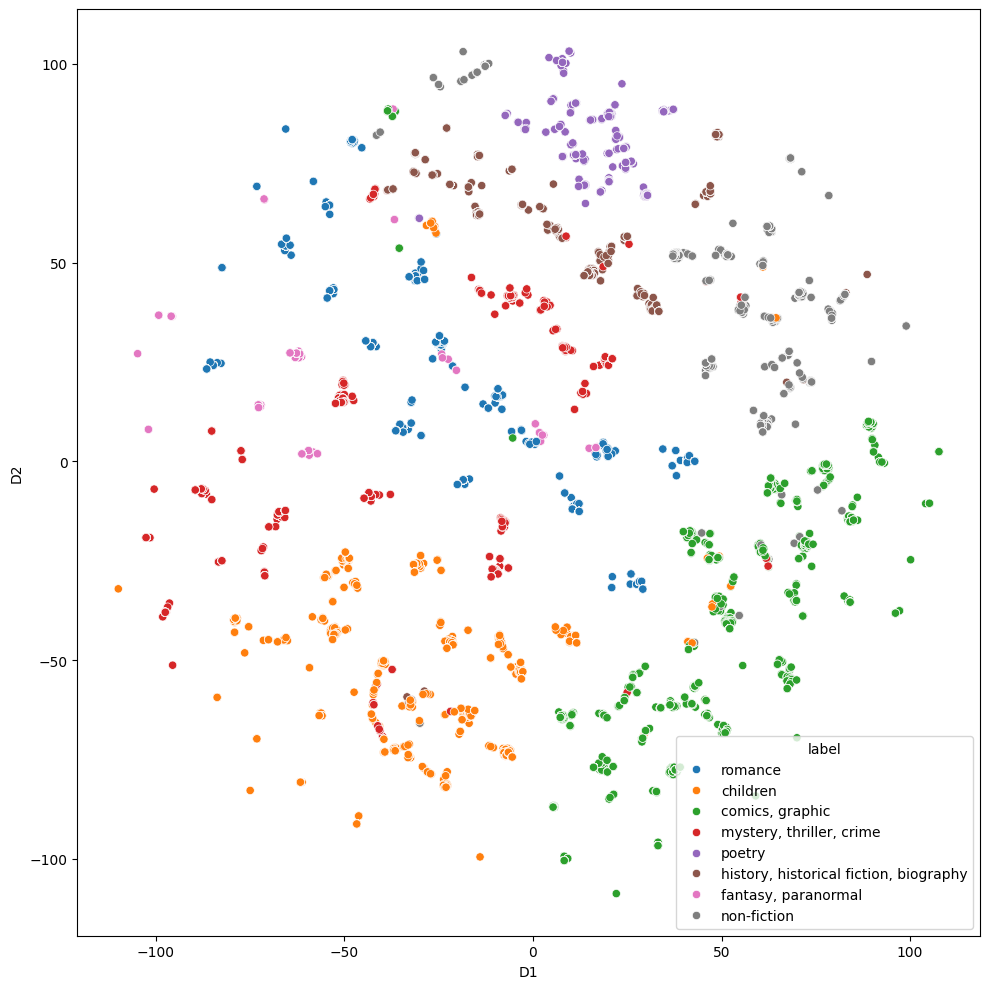

In [148]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df2d, x="D1", y="D2", hue="label")
plt.tight_layout()
plt.show()

## Distanze

In [154]:
from sklearn.metrics.pairwise import euclidean_distances

In [155]:
sigma = euclidean_distances(profile_mdf, profile_mdf)

In [156]:
sigma.shape

(17103, 17103)

In [168]:
sim_0 = pd.Series(sigma[2687], index=user_list)

In [173]:
sim_0.sort_values(ascending=True).head(10)

22001    0.0
1198     0.0
38471    0.0
46121    0.0
82751    0.0
58730    0.0
6927     0.0
642      0.0
45686    0.0
20591    0.0
dtype: float64

In [170]:
profiles[profiles.user_id_mapping == 22001]

,user_id_mapping,genre,score
24541,22001,children,4.0
24542,22001,"comics, graphic",4.0
24543,22001,fiction,4.0
24544,22001,"history, historical fiction, biography",4.0
24545,22001,"mystery, thriller, crime",4.0
24546,22001,non-fiction,4.0
24547,22001,young-adult,4.0


In [172]:
profiles[profiles.user_id_mapping == 35207]

,user_id_mapping,genre,score
38296,35207,fiction,5.0
38297,35207,poetry,5.0
38298,35207,romance,5.0
38299,35207,young-adult,5.0


## Clustering

In [185]:
from sklearn.cluster import KMeans, AgglomerativeClustering

In [186]:
k_means = KMeans(n_clusters=6)
a_means = AgglomerativeClustering(n_clusters=6)

In [187]:
assigment_kmeans = k_means.fit_predict(profile_2d)
assigment_ameans = a_means.fit_predict(profile_2d)

/Users/flint/.pyenv/versions/3.9.17/envs/nlp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [181]:
assigment_kmeans

array([4, 2, 0, ..., 5, 2, 4], dtype=int32)

In [188]:
df2d['kmeans'] = assigment_kmeans
df2d['ameans'] = assigment_ameans

In [189]:
df2d

,D1,D2,label,kmeans,ameans
2,10.781442,-11.261732,romance,5,5
4,-21.499943,-45.568783,children,2,1
7,63.295113,-5.626843,"comics, graphic",0,2
21,-77.080658,0.477686,"mystery, thriller, crime",1,4
23,36.681530,-78.530052,"comics, graphic",2,3
...,...,...,...,...,...
84173,47.389942,25.766632,non-fiction,3,2
84179,-64.411804,27.300535,"fantasy, paranormal",1,4
84212,47.389942,25.766632,non-fiction,3,2
84260,-59.242809,-51.888172,children,1,1


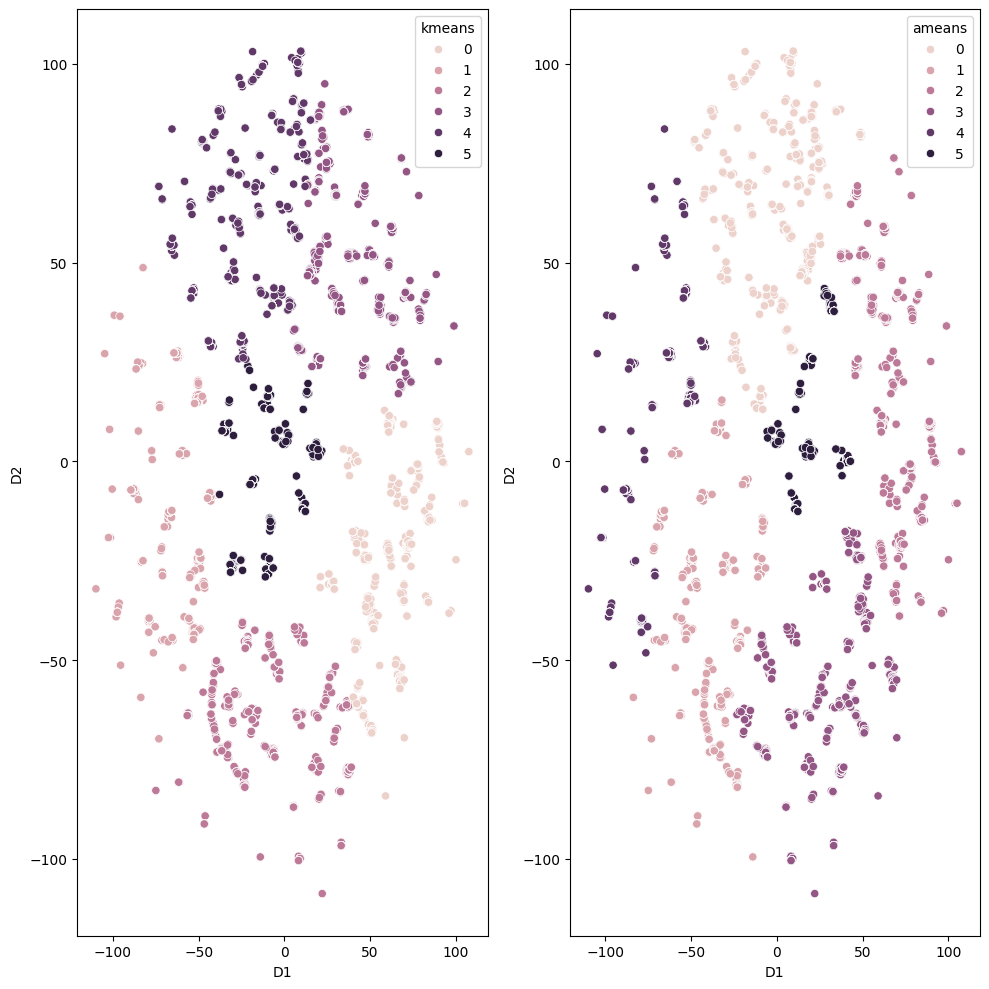

In [190]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=2)
sns.scatterplot(data=df2d, x="D1", y="D2", hue="kmeans", ax=ax[0])
sns.scatterplot(data=df2d, x="D1", y="D2", hue="ameans", ax=ax[1])
plt.tight_layout()
plt.show()